In [ ]:
import numpy as np
import struct
import os
import json
import zipfile
from scipy.optimize import root_scalar

# ---- EDIT THIS ----
zip_path = r'C:\Users\klipk\Downloads\raw_heatdata_logs\teensy_raw_490.zip'  # Path to your ZIP file
bin_base = 'teensy_raw_'  # Base file name inside the ZIP

# ---- CONSTANTS: must match Arduino/Python ----
V_REF       = 3.3
ADC_MAX_10  = 1023.0
ADC_MAX_12  = 4095.0
R_REF       = 1000.0

S_HIGH      = 50
S_LOW       = 16000

BYTES_H     = S_HIGH * 2
BYTES_TH    = 4
BYTES_L     = S_LOW * 2
BYTES_TL1   = 4
BYTES_TL2   = 4
BYTES_AG    = 4

TOTAL_BYTES = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL1 + BYTES_TL2 + BYTES_AG

R0 = 1000.0  # Ohms for Pt1000
A = 3.9083e-3
B = -5.775e-7
C_neg = -4.183e-12  # Only used for T < 0

def pt1000_lookup(R_measured):
    """
    Given resistance R in ohms, return the corresponding temperature in °C
    using the inverse of the Callendar–Van Dusen equation for Pt1000.
    """
    def R_of_T(T):
        C = C_neg if T < 0 else 0.0
        return R0 * (1 + A*T + B*T**2 + C*(T - 100)*T**3)

    # Define the root function: R(T) - R_measured = 0
    def residual(T):
        return R_of_T(T) - R_measured

    # Try solving between -200°C and 850°C (valid for Pt1000)
    sol = root_scalar(residual, bracket=[-200, 850], method='brentq')

    if sol.converged:
        return sol.root
    else:
        return None  # Or raise an error if desired


def parse_teensy_bin(raw):
    idx = 0
    vh        = np.frombuffer(raw[idx:idx+BYTES_H],   dtype=np.uint16); idx += BYTES_H
    t_high    = struct.unpack('<I',  raw[idx:idx+BYTES_TH])[0];       idx += BYTES_TH
    vl        = np.frombuffer(raw[idx:idx+BYTES_L],   dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I',  raw[idx:idx+BYTES_TL1])[0];      idx += BYTES_TL1
    totalLow  = struct.unpack('<I',  raw[idx:idx+BYTES_TL2])[0];      idx += BYTES_TL2
    avg_count = struct.unpack('<f',  raw[idx:idx+BYTES_AG])[0]        # float32

    # Compute timing per sample:
    dt_h = t_high / S_HIGH
    dt_l1 = totalLow1 / 1200.0         # First 1200 low-speed samples
    dt_l2 = (totalLow - totalLow1) / (S_LOW - 1200.0)  # Remaining low-speed samples

    t_h = np.arange(S_HIGH) * dt_h
    t_l1 = t_h[-1] + dt_h + np.arange(1200) * dt_l1
    t_l2 = t_l1[-1] + dt_l1 + np.arange(S_LOW - 1200) * dt_l2

    # Convert ADC counts to voltages
    v_h = vh * (V_REF / ADC_MAX_10)
    v_l1 = vl[:1200] * (V_REF / ADC_MAX_12)
    v_l2 = vl[1200:] * (V_REF / ADC_MAX_12)

    # Calculate temperature from thermistor ADC average count
    V_th = avg_count / ADC_MAX_10 * V_REF
    if V_th == 0 or V_th >= V_REF:
        T_C = None
    else:
        R_th = R_REF * V_th / (V_REF - V_th)
        T_C = pt1000_lookup(R_th)

    return t_h, v_h, t_l1, v_l1, t_l2, v_l2, T_C

# --- Load all data from ZIP ---
all_times = []
all_voltages = []
all_temperatures = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    bin_files = [f for f in zip_ref.namelist() if f.startswith(bin_base) and f.endswith('.bin')]

    for fname in bin_files:
        info = zip_ref.getinfo(fname)
        if info.file_size != TOTAL_BYTES:
            print(f"Skipping {fname}: wrong size ({info.file_size} bytes)")
            continue
        with zip_ref.open(fname) as f:
            raw = f.read()
            try:
                t_h, v_h, t_l1, v_l1, t_l2, v_l2, T_C = parse_teensy_bin(raw)
                t_all = np.concatenate((t_h, t_l1, t_l2))
                v_all = np.concatenate((v_h, v_l1, v_l2))
                all_times.append(t_all)
                all_voltages.append(v_all)
                all_temperatures.append(T_C)
                print(f"Loaded {fname} at T = {T_C:.2f}°C")
            except Exception as e:
                print(f"Skipping {fname}: {e}")

# --- Bin by temperature (nearest 5°C) and average ---
delta_T = 5
binned = {}

for t, v, T in zip(all_times, all_voltages, all_temperatures):
    if T is None:
        continue
    T_bin = delta_T * round(T / delta_T)
    if T_bin not in binned:
        binned[T_bin] = {'times': [], 'voltages': [], 'temps': []}
    binned[T_bin]['times'].append(t)
    binned[T_bin]['voltages'].append(v)
    binned[T_bin]['temps'].append(T)

results = []
for T_bin in sorted(binned.keys()):
    times_stack = np.stack(binned[T_bin]['times'])
    volts_stack = np.stack(binned[T_bin]['voltages'])
    temps = binned[T_bin]['temps']

    t_avg = np.mean(times_stack, axis=0)
    v_avg = np.mean(volts_stack, axis=0)
    T_avg = np.mean(temps)

    results.append((t_avg, v_avg, T_avg))
    print(f"Binned {len(temps)} runs near {T_bin}°C, average T = {T_avg:.2f}°C")

# Now results contains averaged time, voltage, and temperature per 5°C bin


Skipping teensy_raw_490.bin: wrong size (34012 bytes)
Skipping teensy_raw_489.bin: wrong size (34012 bytes)
Skipping teensy_raw_488.bin: wrong size (34012 bytes)
Skipping teensy_raw_487.bin: wrong size (34012 bytes)
Skipping teensy_raw_486.bin: wrong size (34012 bytes)
Skipping teensy_raw_485.bin: wrong size (34012 bytes)
Skipping teensy_raw_484.bin: wrong size (34012 bytes)
Skipping teensy_raw_483.bin: wrong size (34012 bytes)
Skipping teensy_raw_482.bin: wrong size (34012 bytes)
Skipping teensy_raw_481.bin: wrong size (34012 bytes)
Skipping teensy_raw_480.bin: wrong size (34012 bytes)
Skipping teensy_raw_479.bin: wrong size (34012 bytes)
Skipping teensy_raw_478.bin: wrong size (34012 bytes)
Skipping teensy_raw_477.bin: wrong size (34012 bytes)
Skipping teensy_raw_476.bin: wrong size (34012 bytes)
Skipping teensy_raw_475.bin: wrong size (34012 bytes)
Skipping teensy_raw_474.bin: wrong size (34012 bytes)
Skipping teensy_raw_473.bin: wrong size (34012 bytes)
Skipping teensy_raw_472.bin:

C:\Users\klipk\AppData\Local\Temp\ipykernel_12676\1640065486.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e6)


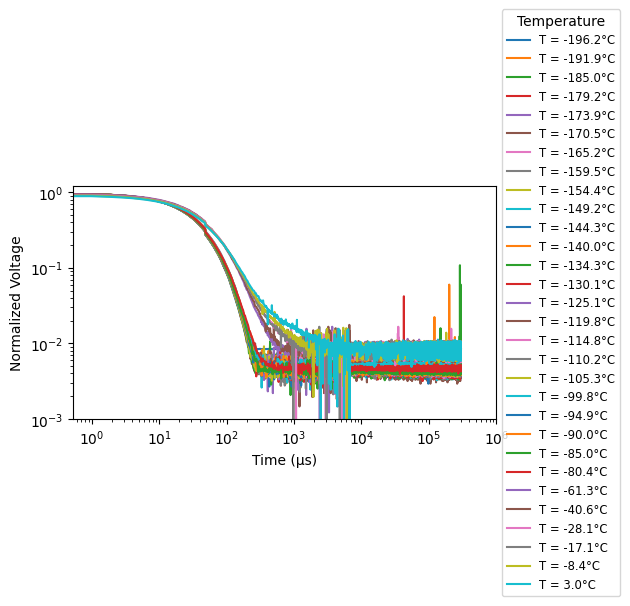

In [4]:
import matplotlib.pyplot as plt

# Plot all bins with T < -30°C (adjust as needed)
for tgg, Vgg, Tgg in results:
    tgg = np.asarray(tgg).flatten()
    Vgg = np.asarray(Vgg).flatten()
    if Tgg < 10:
        plt.plot(tgg, Vgg / 3.3, label=f'T = {Tgg:3.1f}°C')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 1e6)
plt.ylim(1e-3, 1.2)
plt.xlabel("Time (μs)")
plt.ylabel("Normalized Voltage")
plt.legend(title="Temperature", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

In [5]:
# Focus on the critical temperature range for sucrose
plt.figure(figsize=(12, 8))

# Plot only temperatures near expected Tg (-32 to -40°C)
for ds_name, ds in data["datasets"].items():
    T = ds["temperature"]
    if -50 < T < -20:  # Focus on glass transition range
        x = np.array(ds["x"])
        y = np.array(ds["y"]) / np.array(ds["y"])[0]
        plt.plot(x, y, label=f'T = {T:.0f}°C', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time (μs)')
plt.ylabel('Normalized Signal')
plt.title('50% Sucrose Solution - Glass Transition Region')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'data' is not defined

<Figure size 1200x800 with 0 Axes>

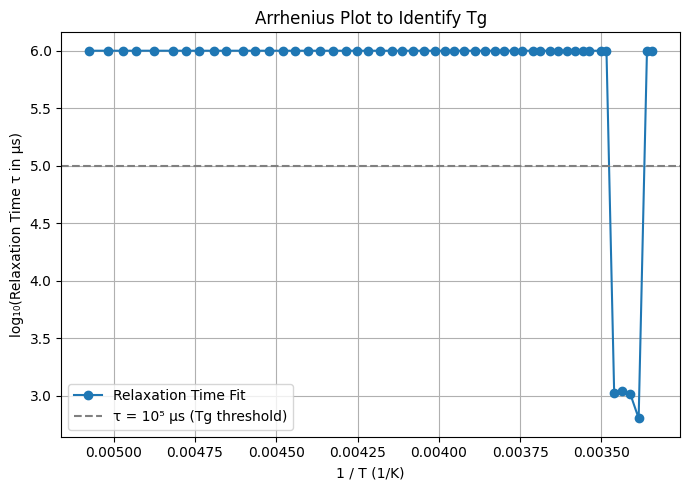

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import struct
import zipfile

# === CONFIG ===
zip_path = r'C:\Users\klipk\Downloads\test7_logs\teensy_raw_3931.zip'
bin_base = 'teensy_raw_'
delta_T = 2

# === CONSTANTS ===
V_REF = 3.3
ADC_MAX_10 = 1023.0
ADC_MAX_12 = 4095.0
R_REF = 1000.0
S_HIGH = 50
S_LOW = 16000
BYTES_H = S_HIGH * 2
BYTES_TH = 4
BYTES_L = S_LOW * 2
BYTES_TL1 = 4
BYTES_TL2 = 4
BYTES_AG = 4
TOTAL_BYTES = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL1 + BYTES_TL2 + BYTES_AG

def pt1000_lookup(R):
    T_ref = np.array([-79, -70, -60, -50, -40, -30,
                      -20, -10, 0, 10, 20, 30])
    R_ref = np.array([687.30, 723.30, 763.30, 803.10,
                      842.70, 882.20, 921.60, 960.90,
                      1000.00, 1039.00, 1077.90, 1116.70])
    return np.interp(R, R_ref, T_ref)

def parse_teensy_bin(raw):
    idx = 0
    vh = np.frombuffer(raw[idx:idx+BYTES_H], dtype=np.uint16); idx += BYTES_H
    t_high = struct.unpack('<I', raw[idx:idx+BYTES_TH])[0]; idx += BYTES_TH
    vl = np.frombuffer(raw[idx:idx+BYTES_L], dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I', raw[idx:idx+BYTES_TL1])[0]; idx += BYTES_TL1
    totalLow = struct.unpack('<I', raw[idx:idx+BYTES_TL2])[0]; idx += BYTES_TL2
    avg_count = struct.unpack('<f', raw[idx:idx+BYTES_AG])[0]

    dt_h = t_high / S_HIGH
    dt_l1 = totalLow1 / 1200.0
    dt_l2 = (totalLow - totalLow1) / (S_LOW - 1200.0)

    t_h = np.arange(S_HIGH) * dt_h
    t_l1 = t_h[-1] + dt_h + np.arange(1200) * dt_l1
    t_l2 = t_l1[-1] + dt_l1 + np.arange(S_LOW - 1200) * dt_l2

    v_h = vh * (V_REF / ADC_MAX_10)
    v_l1 = vl[:1200] * (V_REF / ADC_MAX_12)
    v_l2 = vl[1200:] * (V_REF / ADC_MAX_12)

    V_th = avg_count / ADC_MAX_10 * V_REF
    if V_th == 0 or V_th >= V_REF:
        T_C = None
    else:
        R_th = R_REF * V_th / (V_REF - V_th)
        T_C = pt1000_lookup(R_th)

    t_all = np.concatenate((t_h, t_l1, t_l2))
    v_all = np.concatenate((v_h, v_l1, v_l2))

    return t_all, v_all, T_C

# === Load and bin ===
all_times, all_volts, all_temps = [], [], []
with zipfile.ZipFile(zip_path, 'r') as zf:
    bin_files = [f for f in zf.namelist() if f.startswith(bin_base) and f.endswith('.bin')]
    for fname in bin_files:
        info = zf.getinfo(fname)
        if info.file_size != TOTAL_BYTES:
            continue
        with zf.open(fname) as f:
            try:
                t, v, T = parse_teensy_bin(f.read())
                if T is not None:
                    all_times.append(t)
                    all_volts.append(v)
                    all_temps.append(T)
            except Exception:
                continue

binned = {}
for t, v, T in zip(all_times, all_volts, all_temps):
    T_bin = delta_T * round(T / delta_T)
    binned.setdefault(T_bin, {'times': [], 'voltages': [], 'temps': []})
    binned[T_bin]['times'].append(t)
    binned[T_bin]['voltages'].append(v)
    binned[T_bin]['temps'].append(T)

results = []
for T_bin in sorted(binned):
    times_stack = np.stack(binned[T_bin]['times'])
    volts_stack = np.stack(binned[T_bin]['voltages'])
    T_avg = np.mean(binned[T_bin]['temps'])
    t_avg = np.mean(times_stack, axis=0)
    v_avg = np.mean(volts_stack, axis=0)
    results.append((t_avg, v_avg, T_avg))

# === Fit relaxation curves ===
def stretched_exp(t, tau, beta):
    return np.exp(- (t / tau) ** beta)

relaxation_times = []
temperatures_K = []

for t, V, T_C in results:
    T_K = T_C + 273.15

    # Detect nearly flat voltage = glassy
    if np.std(V[-1000:]) < 0.001:
        # Flat tail — likely glassy: assign long τ
        tau = 1e6  # 1 second in μs
        beta = 0.6
    else:
        try:
            popt, _ = curve_fit(stretched_exp, t, V, p0=(1e3, 0.7), bounds=([1, 0.1], [1e6, 1.0]))
            tau, beta = popt
        except Exception:
            tau = 1e6  # fallback for poor fit
            beta = 0.6

    relaxation_times.append(tau)
    temperatures_K.append(T_K)

# === Plot Arrhenius τ(T) ===
inv_T = 1 / np.array(temperatures_K)
log_tau = np.log10(relaxation_times)

plt.figure(figsize=(7, 5))
plt.plot(inv_T, log_tau, 'o-', label="Relaxation Time Fit")
plt.axhline(np.log10(1e5), color='gray', linestyle='--', label="τ = 10⁵ μs (Tg threshold)")
plt.xlabel("1 / T (1/K)")
plt.ylabel("log₁₀(Relaxation Time τ in μs)")
plt.title("Arrhenius Plot to Identify Tg")
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()


Parsed 4267 runs.

=== GAP BOUNDARIES ===
- raw_binary146.bin (2025-06-26 11:30:06) -> raw_binary147.bin (2025-06-26 11:30:54)  [gap=48.0s]
- raw_binary397.bin (2025-06-26 11:33:32) -> raw_binary398.bin (2025-06-26 11:35:22)  [gap=110.0s]
- raw_binary779.bin (2025-06-26 11:39:30) -> raw_binary780.bin (2025-06-26 11:40:16)  [gap=46.0s]
- raw_binary1198.bin (2025-06-26 11:45:04) -> raw_binary1199.bin (2025-06-26 11:46:08)  [gap=64.0s]
- raw_binary1233.bin (2025-06-26 11:46:32) -> raw_binary1234.bin (2025-06-26 11:47:48)  [gap=76.0s]
- raw_binary3617.bin (2025-06-26 12:19:34) -> raw_binary3618.bin (2025-06-26 12:44:48)  [gap=1514.0s]
- raw_binary3977.bin (2025-06-26 12:50:56) -> raw_binary3978.bin (2025-06-26 13:10:34)  [gap=1178.0s]
- raw_binary3978.bin (2025-06-26 13:10:34) -> raw_binary3979.bin (2025-06-26 13:16:10)  [gap=336.0s]
- raw_binary4014.bin (2025-06-26 13:16:48) -> raw_binary4015.bin (2025-06-26 13:18:32)  [gap=104.0s]


C:\Users\klipk\AppData\Local\Temp\ipykernel_23000\4182076791.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


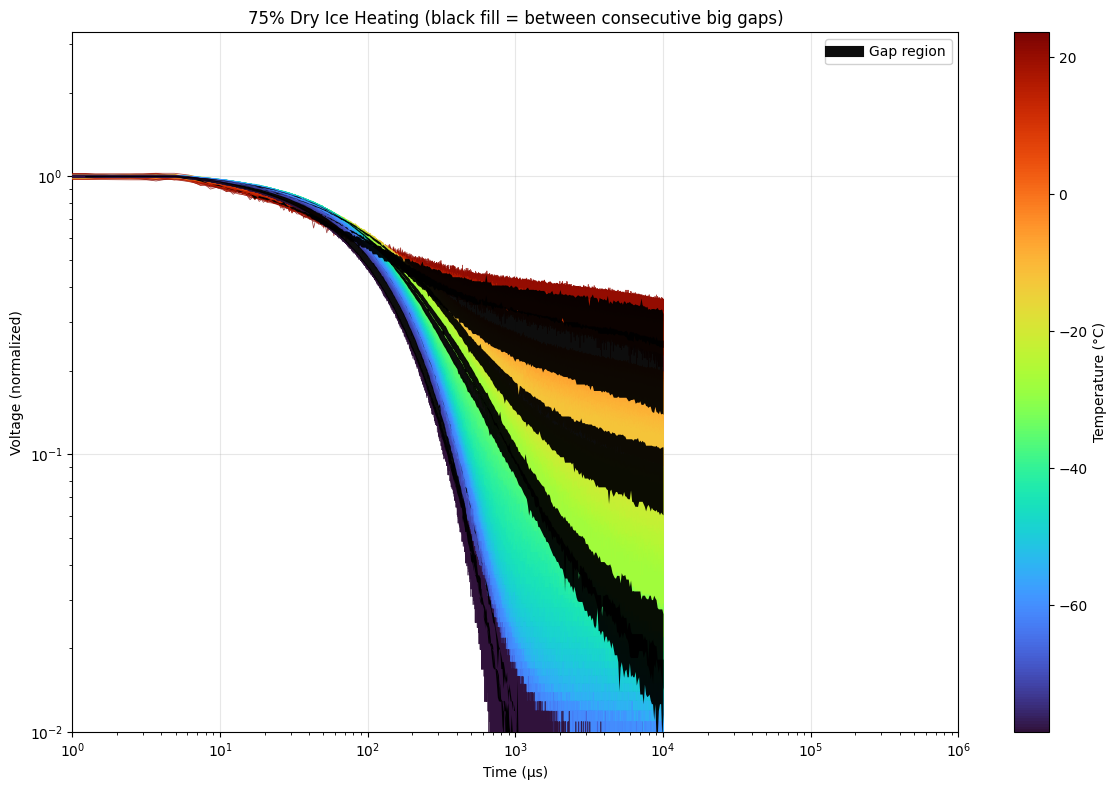


=== BLACK REGIONS (where fill starts/ends) ===
- raw_binary146.bin  (2025-06-26 11:30:06)  ->  raw_binary147.bin  (2025-06-26 11:30:54)  | gap=48.0s  | overlap t: [1.226834330362593, 10049.000000000005] µs
- raw_binary397.bin  (2025-06-26 11:33:32)  ->  raw_binary398.bin  (2025-06-26 11:35:22)  | gap=110.0s  | overlap t: [1.226834330362593, 10049.000000000005] µs
- raw_binary779.bin  (2025-06-26 11:39:30)  ->  raw_binary780.bin  (2025-06-26 11:40:16)  | gap=46.0s  | overlap t: [1.226834330362593, 10049.000000000005] µs
- raw_binary1198.bin  (2025-06-26 11:45:04)  ->  raw_binary1199.bin  (2025-06-26 11:46:08)  | gap=64.0s  | overlap t: [1.226834330362593, 10049.000000000005] µs
- raw_binary1233.bin  (2025-06-26 11:46:32)  ->  raw_binary1234.bin  (2025-06-26 11:47:48)  | gap=76.0s  | overlap t: [1.226834330362593, 10049.000000000005] µs
- raw_binary3617.bin  (2025-06-26 12:19:34)  ->  raw_binary3618.bin  (2025-06-26 12:44:48)  | gap=1514.0s  | overlap t: [1.226834330362593, 10049.000000

In [12]:
import re, zipfile, datetime, csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from read_teensy_binary import get_teensy_binary_data

# === INPUT ZIP ===
zip_path = r'C:\Users\klipk\Downloads\raw_binary4091.zip'

# === GAP DETECTION PARAM ===
GAP_SECS = 30  # mark gaps >= this many seconds

# === PLOT CONFIG ===
TITLE = "75% Dry Ice Heating (black fill = between consecutive big gaps)"
XLIM = (1, 1e6)
YLIM = (1e-2, 3.3)

# Save a CSV of the black regions? (set to None to skip)
CSV_OUT = r"C:\Users\klipk\Downloads\black_regions.csv"

# ---------- helpers ----------
def normalize_voltage(V):
    V = np.asarray(V, float)
    v0 = next((v for v in V if v > 0), None)
    if v0 is None: return None
    return V / v0

def valid_tv(t, v):
    t = np.asarray(t, float); v = np.asarray(v, float)
    m = (t > 0) & (v > 0) & np.isfinite(v)
    return t[m], v[m]

def fill_between_two(ax, tA, vA, tB, vB, *, color='black', alpha=0.85, npts=400, z=10):
    """
    Fill area between two curves on overlapping t-range (log-spaced grid).
    Returns (t_overlap_lo, t_overlap_hi) if filled, else None.
    """
    tA, vA = valid_tv(tA, vA)
    tB, vB = valid_tv(tB, vB)
    if len(tA) < 2 or len(tB) < 2:
        return None

    lo = max(tA.min(), tB.min())
    hi = min(tA.max(), tB.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return None

    # common log-spaced grid over overlap
    xg = np.logspace(np.log10(lo), np.log10(hi), npts)
    yA = np.interp(xg, tA, vA)
    yB = np.interp(xg, tB, vB)

    mask = (yA > 0) & (yB > 0) & np.isfinite(yA) & np.isfinite(yB)
    if np.count_nonzero(mask) < 2:
        return None

    ax.fill_between(xg[mask], yA[mask], yB[mask],
                    color=color, alpha=alpha, edgecolor='none', zorder=z)
    return float(xg[mask][0]), float(xg[mask][-1])

# ------------- STEP 1: Parse ZIP + load data -------------
num_re = re.compile(r"^raw_binary(\d+)\.bin$")

with zipfile.ZipFile(zip_path, 'r') as z:
    entries = []
    for info in z.infolist():
        m = num_re.match(info.filename)
        if not m:
            continue
        n = int(m.group(1))
        Y, M, D, h, m_, s = info.date_time
        dt = datetime.datetime(Y, M, D, h, m_, s)
        entries.append((n, info.filename, dt))
    if not entries:
        raise SystemExit("No raw_binary*.bin entries found in ZIP.")

    entries.sort(key=lambda r: r[0])  # numeric order

    M_times, M_voltages, M_temperatures = [], [], []
    for i, (_, name, _) in enumerate(entries, 1):
        with z.open(name) as f:
            t, V, T_therm = get_teensy_binary_data(f)
        M_times.append(np.asarray(t))
        M_voltages.append(np.asarray(V))
        M_temperatures.append(float(np.mean(T_therm)))

print(f"Parsed {len(M_times)} runs.")

# ------------- STEP 2: Find big-gap boundaries by ZIP time -------------
gap_boundaries = []
for i in range(len(entries) - 1):
    dtA = entries[i][2]; dtB = entries[i+1][2]
    if (dtB - dtA).total_seconds() >= GAP_SECS:
        gap_boundaries.append(i)

print("\n=== GAP BOUNDARIES ===")
for i in gap_boundaries:
    a = entries[i]; b = entries[i+1]
    print(f"- {a[1]} ({a[2]}) -> {b[1]} ({b[2]})  [gap={(b[2]-a[2]).total_seconds():.1f}s]")

# ------------- STEP 3: Plot turbo curves -------------
temps = np.array(M_temperatures)
cmap = cm.get_cmap('turbo')
norm = mcolors.Normalize(vmin=float(np.nanmin(temps)), vmax=float(np.nanmax(temps)))

fig, ax = plt.subplots(figsize=(12, 8))

# draw all runs in turbo (unchanged)
for t, V, T in zip(M_times, M_voltages, M_temperatures):
    Vn = normalize_voltage(V)
    if Vn is None or len(t) < 2:
        continue
    ax.plot(t, Vn, color=cmap(norm(T)), alpha=0.75, linewidth=0.55, zorder=3)

# ------------- STEP 4: FILL BETWEEN & COLLECT METADATA -------------
black_regions = []  # will hold dicts with start/end file + timestamps + overlap info

for i in gap_boundaries:
    (nA, nameA, dtA) = entries[i]
    (nB, nameB, dtB) = entries[i+1]
    gap_s = (dtB - dtA).total_seconds()

    VnA = normalize_voltage(M_voltages[i])
    VnB = normalize_voltage(M_voltages[i+1])
    if VnA is None or VnB is None:
        continue

    overlap = fill_between_two(ax, M_times[i], VnA, M_times[i+1], VnB,
                               color='black', alpha=0.95, npts=500, z=15)
    if overlap is None:
        # no overlapping t-range to fill—still record the pair
        black_regions.append({
            'start_file': nameA, 'start_dt': dtA.isoformat(sep=' '),
            'end_file': nameB,   'end_dt': dtB.isoformat(sep=' '),
            'gap_seconds': gap_s,
            'overlap_t_lo_us': None, 'overlap_t_hi_us': None
        })
    else:
        t_lo, t_hi = overlap
        black_regions.append({
            'start_file': nameA, 'start_dt': dtA.isoformat(sep=' '),
            'end_file': nameB,   'end_dt': dtB.isoformat(sep=' '),
            'gap_seconds': gap_s,
            'overlap_t_lo_us': t_lo, 'overlap_t_hi_us': t_hi
        })

# axes, labels
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(*XLIM);   ax.set_ylim(*YLIM)
ax.set_xlabel('Time (µs)'); ax.set_ylabel('Voltage (normalized)')
ax.set_title(TITLE);  ax.grid(True, alpha=0.3)

# colorbar + legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax); cbar.set_label("Temperature (°C)")
ax.legend([Line2D([0],[0], color='black', lw=8, alpha=0.95)], ['Gap region'], loc='upper right', framealpha=0.9)

plt.tight_layout(); plt.show()

# ------------- STEP 5: PRINT & OPTIONAL CSV -------------
print("\n=== BLACK REGIONS (where fill starts/ends) ===")
if not black_regions:
    print("None.")
else:
    for r in black_regions:
        print(f"- {r['start_file']}  ({r['start_dt']})  ->  {r['end_file']}  ({r['end_dt']})"
              f"  | gap={r['gap_seconds']:.1f}s"
              f"  | overlap t: [{r['overlap_t_lo_us']}, {r['overlap_t_hi_us']}] µs")

    if CSV_OUT:
        with open(CSV_OUT, 'w', newline='') as f:
            w = csv.DictWriter(f, fieldnames=list(black_regions[0].keys()))
            w.writeheader()
            w.writerows(black_regions)
        print(f"\nSaved CSV with black-region metadata to: {CSV_OUT}")


C:\Users\klipk\AppData\Local\Temp\ipykernel_21412\275037600.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


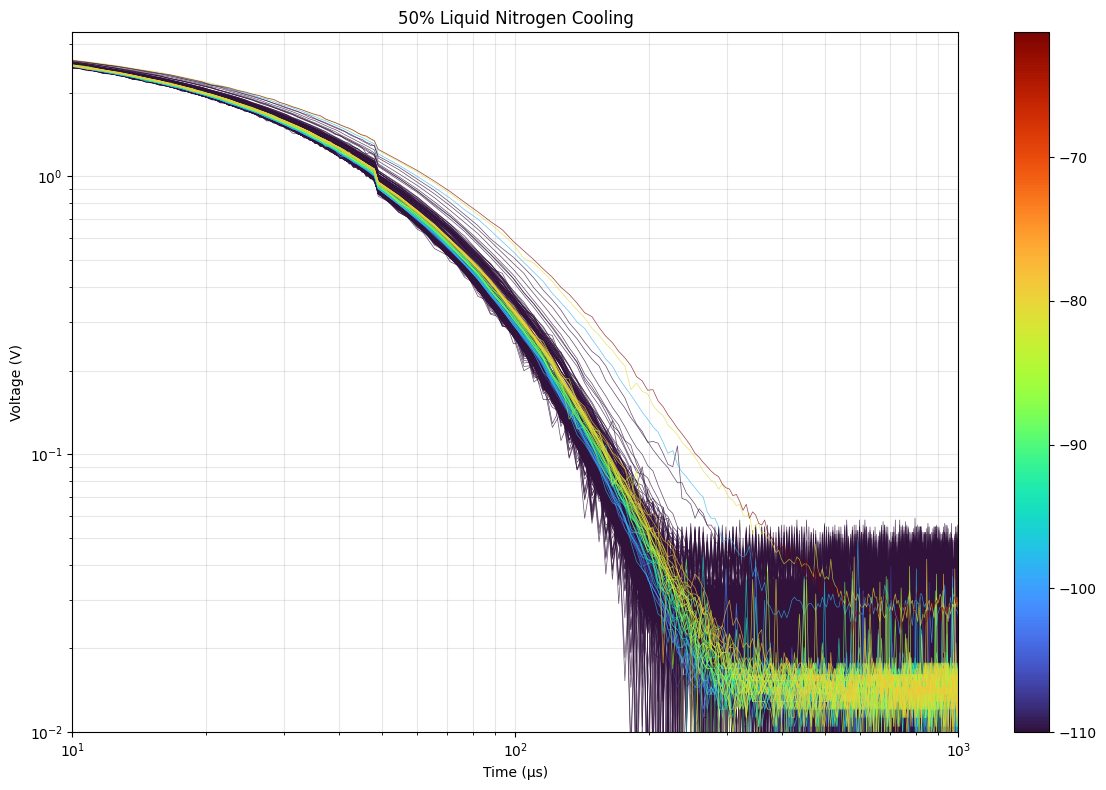

: 

In [ ]:
# ========= CONFIG (EDIT THESE) =========
zip_path  = r'C:\Users\klipk\Downloads\test7_logs\teensy_raw_1553.zip'
bin_base  = 'teensy_raw_'
PLOT_TITLE = '50% Liquid Nitrogen Cooling'
XLIM = (10, 1000)        # µs
YLIM = (1e-2, 3.3)       # volts
TEMP_RANGE = (-200, -50)   # area of interest in °C
# ======================================

# ---- Constants ----
V_REF       = 3.3
ADC_MAX_10  = 1023.0
ADC_MAX_12  = 4095.0
R_REF       = 1000.0
S_HIGH      = 50
BYTES_H     = S_HIGH * 2
BYTES_TH    = 4
BYTES_TL1   = 4
BYTES_TL2   = 4
BYTES_AG    = 4
N1_FIRST    = 1200

# Pt1000 constants
R0   = 1000.0
A    = 3.9083e-3
B    = -5.775e-7
Cneg = -4.183e-12

def pt1000_lookup(R_measured):
    """Invert Callendar–Van Dusen; clamp below -110°C."""
    def R_of_T(T):
        C = Cneg if T < 0 else 0.0
        return R0 * (1 + A*T + B*T**2 + C*(T - 100.0)*T**3)
    def residual(T):
        return R_of_T(T) - R_measured
    try:
        sol = root_scalar(residual, bracket=[-200.0, 850.0], method='brentq')
        if sol.converged:
            return max(sol.root, -110.0)  # clamp
        return None
    except Exception:
        return None

def parse_teensy_record(raw_bytes):
    total_size = len(raw_bytes)
    header_fixed = BYTES_H + BYTES_TH + BYTES_TL1 + BYTES_TL2 + BYTES_AG
    rem = total_size - header_fixed
    S_LOW_inferred = rem // 2
    idx = 0
    vh        = np.frombuffer(raw_bytes[idx:idx+BYTES_H], dtype=np.uint16); idx += BYTES_H
    t_high    = struct.unpack('<I', raw_bytes[idx:idx+BYTES_TH])[0];       idx += BYTES_TH
    BYTES_L   = S_LOW_inferred * 2
    vl        = np.frombuffer(raw_bytes[idx:idx+BYTES_L], dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I', raw_bytes[idx:idx+BYTES_TL1])[0];      idx += BYTES_TL1
    totalLow  = struct.unpack('<I', raw_bytes[idx:idx+BYTES_TL2])[0];      idx += BYTES_TL2
    avg_count = struct.unpack('<f', raw_bytes[idx:idx+BYTES_AG])[0];       idx += BYTES_AG

    n1  = min(N1_FIRST, S_LOW_inferred)
    n2  = max(S_LOW_inferred - n1, 0)
    dt_h  = t_high / float(S_HIGH)
    dt_l1 = (totalLow1 / float(n1)) if n1 > 0 else 0.0
    dt_l2 = ((totalLow - totalLow1) / float(n2)) if n2 > 0 else 0.0

    t_h   = np.arange(S_HIGH, dtype=float) * dt_h
    t_l1  = (t_h[-1] + dt_h) + np.arange(n1, dtype=float) * dt_l1 if n1 > 0 else np.array([], dtype=float)
    start_l2 = (t_l1[-1] + dt_l1) if n1 > 0 else (t_h[-1] + dt_h)
    t_l2  = start_l2 + np.arange(n2, dtype=float) * dt_l2 if n2 > 0 else np.array([], dtype=float)

    v_h  = vh.astype(float)  * (V_REF / ADC_MAX_10)
    v_l1 = vl[:n1].astype(float) * (V_REF / ADC_MAX_12) if n1 > 0 else np.array([], dtype=float)
    v_l2 = vl[n1:n1+n2].astype(float) * (V_REF / ADC_MAX_12) if n2 > 0 else np.array([], dtype=float)

    V_th = (avg_count / ADC_MAX_10) * V_REF
    if 0.0 < V_th < V_REF:
        R_th = R_REF * V_th / (V_REF - V_th)
        T_C  = pt1000_lookup(R_th)
    else:
        T_C  = None

    t_all = np.concatenate([t_h, t_l1, t_l2])
    v_all = np.concatenate([v_h, v_l1, v_l2])
    return t_all, v_all, T_C, int(S_LOW_inferred)

# -------- Load & filter --------
all_times, all_voltages, all_temps = [], [], []

with zipfile.ZipFile(zip_path, 'r') as zf:
    members = [m for m in zf.namelist() if os.path.basename(m).startswith(bin_base) and m.endswith('.bin')]
    members.sort(key=lambda m: int(os.path.basename(m).replace(bin_base, '').split('.')[0]))
    for m in members:
        with zf.open(m, 'r') as f:
            raw = f.read()
        try:
            t_all, v_all, T_C, _ = parse_teensy_record(raw)
            if T_C is not None and TEMP_RANGE[0] <= T_C <= TEMP_RANGE[1]:
                all_times.append(t_all)
                all_voltages.append(v_all)
                all_temps.append(T_C)
        except Exception as e:
            print(f"Skipping {m}: {e}")

if not all_times:
    raise SystemExit("No records in selected temperature range.")

temps = np.array(all_temps, dtype=float)
tmin, tmax = float(temps.min()), float(temps.max())

# -------- Plot --------
fig, ax = plt.subplots(figsize=(12, 8))
cmap = cm.get_cmap('turbo')
norm = mcolors.Normalize(vmin=tmin, vmax=tmax)

for t, V, T in sorted(zip(all_times, all_voltages, all_temps), key=lambda x: x[2]):
    ax.plot(t, V, color=cmap(norm(T)), alpha=0.75, linewidth=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_xlabel('Time (µs)')
ax.set_ylabel('Voltage (V)')
ax.set_title(PLOT_TITLE)
ax.grid(True, which='both', alpha=0.3)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
fig.colorbar(sm, ax=ax)

plt.tight_layout()
plt.show()
